## I/GET DATA

In [26]:
%pip install -U scikit-learn #install sklearn 1.0.2
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
#Build Transformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,PolynomialFeatures,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.stats import randint
#Suicide rate in countries every year
df_country_suicide_rate=pd.read_csv('DATASET/CLEANED_DATA/country_suicide_rate.csv')

#Suicide rate in over the world every year(full data)
df_suicide_rate=pd.read_csv('DATASET/CLEANED_DATA/suicide_rate.csv')

#Mental health in 2016
df_mental_health_2016=pd.read_csv('DATASET/CLEANED_DATA/mental_health.csv')

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#install'


In [3]:
df_country_suicide_rate.corr().style.background_gradient(cmap='Blues')

,Year,GDP ($),GDP/Capita ($),No.Suicides,Population,Suicides_rate/100k pop
Year,1.000000,0.094001,0.339188,-0.007759,0.008887,-0.015713
GDP ($),0.094001,1.000000,0.303126,0.657589,0.800281,0.071868
GDP/Capita ($),0.339188,0.303126,1.000000,0.093461,0.091413,0.060367
No.Suicides,-0.007759,0.657589,0.093461,1.000000,0.808095,0.360253
Population,0.008887,0.800281,0.091413,0.808095,1.000000,0.083918
Suicides_rate/100k pop,-0.015713,0.071868,0.060367,0.360253,0.083918,1.000000


# II/ PREDICT NO.SUICIDE

## 1/ Prepare data

### Get train data:

In [2]:
df_suicide=df_country_suicide_rate.sort_values(['Year','Country'],ascending=True)
df=df_suicide.drop(columns=['Suicides_rate/100k pop','GDP/Capita ($)']) 
#Get division data
df_div=df[df['Year']==2016]
X_div=df_div.drop(columns=['No.Suicides']) 
y_div=df_div['No.Suicides']
#Get train data
df_train=df[df['Year']!=2016]
X_train=df_train.drop(columns=['No.Suicides']) 
y_train=df_train['No.Suicides']

### Preprocessor

In [4]:
# Define categorical pipeline
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([('poly',PolynomialFeatures(degree = 1, include_bias=False)),('scaler', MinMaxScaler())])

#
col_pipe=Pipeline([('ordi',OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))])

#Find numerical/categorical columns
numerical = list(X_train.select_dtypes('number').columns) 
categorical = ['Country']


tfm = ColumnTransformer(transformers=[('cat', cat_pipe, categorical), 
                                      ('num', num_pipe, numerical)],
                                       remainder='passthrough')
X_train_pre=tfm.fit_transform(X_train)

In [5]:
#Build TimeSeriesSplit

from sklearn.model_selection import TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits = len(X_train['Year'].unique()))

### Function

In [6]:
def build_final_pipe(model,tfm):
  final_pipe=Pipeline(steps=[('preprocessor', tfm),('model',model )])                      
  print(final_pipe.get_params().keys())
  return final_pipe

In [7]:
def train_raw(model,X_train_pre,y_train):
  model.fit(X_train_pre,y_train)
  y_train_pred= model.predict(X_train_pre)
  rfr_rmse = mean_squared_error(y_train,y_train_pred)
  print(f"The MSE is {rfr_rmse:.2f}")
  return model

In [8]:
def train_gsc(model,tfm,param,x,y,k=time_series_split):
  final_pipe=build_final_pipe(model,tfm)
  GSC = GridSearchCV(final_pipe,param_grid=param,scoring='neg_mean_squared_error',cv=k,n_jobs=-1,verbose=True)
  GSC.fit(x,y)
  get_score(GSC)
  return GSC

In [9]:
def get_score(model)  :
  cv = pd.DataFrame(model.cv_results_)
  cv = cv.sort_values('rank_test_score')
  for rec in cv[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score:{rec[1]:.5f} +- {rec[2]:.5f}')
    print('-'*10)

In [10]:
def train_rsc(model,tfm,param,n,x,y,k=time_series_split):
  final_pipe=build_final_pipe(model,tfm)
  RSC = RandomizedSearchCV(final_pipe,param_distributions=param,scoring='neg_mean_squared_error',cv=k,n_jobs=-1,n_iter=n,verbose=True,random_state=42)
  RSC.fit(x,y)
  get_score(RSC)  
  return RSC

In [11]:
#Get back the best_estimator
def get_best_estimator(gsc,X_train,y_train,X_div,y_div):
  best_estimator = gsc.best_estimator_
  best_estimator.fit(X_train,y_train)
# Predict training data
  y_train_pred = best_estimator.predict(X_train)
# MSE on training data
  print("Model MSE on training data= {:5.4f}".format(mean_squared_error(y_train,y_train_pred)))

# Predict div data
  y_test_pred = best_estimator.predict(X_div)
# MSE on div set
  print("Model MSE on div data= {:5.4f}".format(mean_squared_error(y_div,y_test_pred)))
  return best_estimator

In [12]:
def save_model(best_estimator,filename):
  pickle.dump(best_estimator, open(filename,'wb'))

In [13]:
def load_model(filename,X_div, y_div):
  loaded_model = pickle.load(open(filename, 'rb'))
  # Predict div data
  y_test_pred = loaded_model.predict(X_div)
  # MSE on div set
  print("Model MSE on div data= {:5.4f}".format(mean_squared_error(y_div,y_test_pred)))
  return loaded_model

In [15]:
X_train.head()

,Country,Year,GDP ($),Population
22,Antigua and Barbuda,1985,240923926,62574
49,Argentina,1985,88416668900,27090800
119,Australia,1985,180190994861,14562500
149,Austria,1985,69386774475,7110115
197,Bahamas,1985,2320699900,203700


## 2/Choose Model

### Ready Algorithm

In [17]:
%pip install xgboost
%pip install lightgbm
# Get Model
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor

from lightgbm import LGBMRegressor
#Algorithm score table 
rmse_val = {}
#Scoring function:
from sklearn.model_selection import cross_val_score
def score_model(model,X_train,y_train):
  scores = cross_val_score(model,
                         X_train, y_train,
                         scoring="neg_mean_squared_error",
                         cv=time_series_split)
  rmse_score = np.sqrt(-scores)
  mean_score = np.mean(rmse_score)
  return mean_score
#Print model MSE:
def get_score_model(rmse_val):
  rmse_df = pd.DataFrame.from_dict(rmse_val, orient='index').reset_index()
  rmse_df.columns = ["Algorithm","RMSE"]
  rmse_df = rmse_df.sort_values("RMSE", ascending=False).reset_index(drop=True)
  
  return rmse_df

### Scoring Algorithm to choose model

In [18]:
X_train_pre=tfm.fit_transform(X_train)
all_algorithm={'Ridge':Ridge(),'Lasso':Lasso(),'ElasticNet':ElasticNet(),'SVR':SVR(),'KNR':KNR(),'RandomForestRegressor':RandomForestRegressor(),'GradientBoostingRegressor':GradientBoostingRegressor(),'AdaBoostRegressor':AdaBoostRegressor(),'XGBRegressor':XGBRegressor(objective='reg:squarederror'),'LGBMRegressor':LGBMRegressor()}
for i in all_algorithm:
  model=all_algorithm.get(i)
  rmse_val[i]=score_model(model,X_train_pre,y_train)
get_score_model(rmse_val)

,Algorithm,RMSE
0,SVR,7442.716878
1,ElasticNet,6725.983446
2,LGBMRegressor,2514.014978
3,AdaBoostRegressor,1971.267186
4,Ridge,1755.263089
5,Lasso,1499.093475
6,KNR,1364.375859
7,GradientBoostingRegressor,1235.958215
8,RandomForestRegressor,1212.463240
9,XGBRegressor,1080.055125


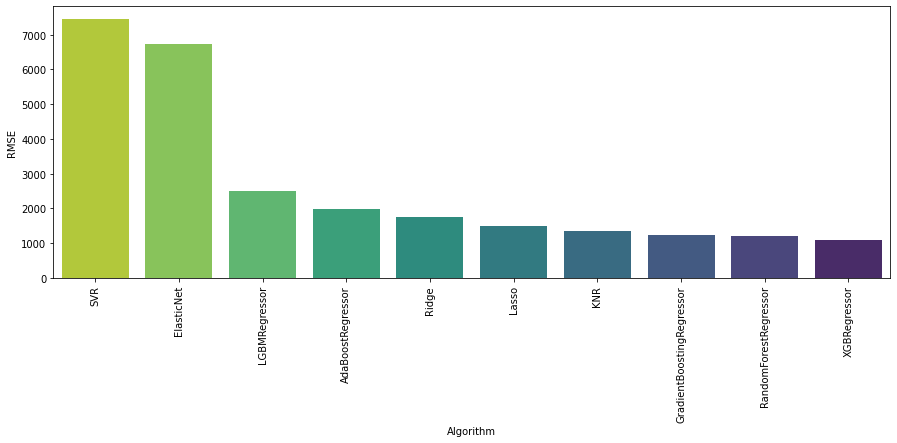

In [19]:
plt.figure(figsize=(15,5))
sns.barplot(data = get_score_model(rmse_val), x="Algorithm", y = "RMSE", palette="viridis_r")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Choose Top 3 Best Algorithm to tuning : RandomForestRegressor,GradientBoostingRegressor,XGBRegressor

Choose Top 3 Best Algorithm to tuning :

1.   GradientBoostingRegressor
2.   RandomForestRegressor
3.  XGBRegressor

##3/Build Model

### Use GradientBoostingRegressor 

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model_raw_gbr=train_raw(model,X_train_pre,y_train)


The MSE is 404547.77


In [ ]:
#Tuning
param_grid = {
              'model__max_depth': randint(low=65, high=180),
              'model__max_features': ['auto'],
              'model__min_samples_leaf': randint(low=2, high=22),
              'model__n_estimators': randint(low=150, high=290)}
              
gbr=train_rsc(model_raw_gbr,tfm,param_grid,10,X_train,y_train)


dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder', 'preprocessor__cat__encoder__categories', 'preprocessor__cat__encoder__drop', 'preprocessor__cat__encoder__dtype', 'preprocessor__cat__encoder__handle_unknown', 'preprocessor__cat__encoder__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__poly', 'preprocessor__num__scaler', 'preprocessor__num__poly__degree', 'preprocessor__num__poly__include_bias', 'preprocessor__num__poly__interaction_only', 'preprocessor__num__poly__order', 'preprocessor__num__scaler__clip', 'preprocessor__num__sca

In [26]:
#Fine Tuning
param_grid = {
              'model__max_depth': np.arange(80,84,2),
              'model__max_features': ['auto'],
              'model__min_samples_leaf': np.arange(2,4),
              'model__n_estimators': np.arange(237,241,2)}
              
gbr=train_gsc(model_raw_gbr,tfm,param_grid,X_train,y_train)


dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder', 'preprocessor__cat__encoder__categories', 'preprocessor__cat__encoder__drop', 'preprocessor__cat__encoder__dtype', 'preprocessor__cat__encoder__handle_unknown', 'preprocessor__cat__encoder__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__poly', 'preprocessor__num__scaler', 'preprocessor__num__poly__degree', 'preprocessor__num__poly__include_bias', 'preprocessor__num__poly__interaction_only', 'preprocessor__num__poly__order', 'preprocessor__num__scaler__clip', 'preprocessor__num__sca

In [27]:
#Get back the best_estimator
best_estimator=get_best_estimator(gbr,X_train,y_train,X_div,y_div)

Model MSE on training data= 209.0703
Model MSE on div data= 26993.4254


In [28]:
# save the model to disk
filename='MODEL_SAVE/GradientBoostingRegressor.sav'
save_model(best_estimator,filename)

In [29]:
# load the model from disk
import pickle
filename='MODEL_SAVE/GradientBoostingRegressor.sav'
gbr_load=load_model(filename,X_div, y_div)

Model MSE on div data= 26993.4254


### Use RandomForestRegressor

In [40]:
#Model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model_raw_rfr=train_raw(model,X_train_pre,y_train)

The MSE is 98512.13


In [ ]:
#Tuning
param_grid = {'preprocessor__num__poly__degree':np.arange(1,20,3),
              'model__max_depth': randint(low=170, high=190),
              'model__max_features': randint(low=20, high=40),
              'model__min_samples_leaf': randint(low=1, high=5),              
              'model__bootstrap': [False],
              'model__n_estimators': randint(low=70, high=90)}
rfr=train_rsc(model_raw_rfr,tfm,param_grid,20,X_train,y_train)

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder', 'preprocessor__cat__encoder__categories', 'preprocessor__cat__encoder__drop', 'preprocessor__cat__encoder__dtype', 'preprocessor__cat__encoder__handle_unknown', 'preprocessor__cat__encoder__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__poly', 'preprocessor__num__scaler', 'preprocessor__num__poly__degree', 'preprocessor__num__poly__include_bias', 'preprocessor__num__poly__interaction_only', 'preprocessor__num__poly__order', 'preprocessor__num__scaler__clip', 'preprocessor__num__sca

In [41]:
#Fine Tuning
param_grid = {'preprocessor__num__poly__degree':np.arange(1,4),
              'model__max_depth':np.arange(183,189,2),
              'model__max_features': np.arange(27,35,2),
              'model__min_samples_leaf': np.arange(1,5,2),              
              'model__bootstrap': [False],
              'model__n_estimators': np.arange(73,85,2)}
rfr=train_gsc(model_raw_rfr,tfm,param_grid,X_train,y_train)


dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder', 'preprocessor__cat__encoder__categories', 'preprocessor__cat__encoder__drop', 'preprocessor__cat__encoder__dtype', 'preprocessor__cat__encoder__handle_unknown', 'preprocessor__cat__encoder__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__poly', 'preprocessor__num__scaler', 'preprocessor__num__poly__degree', 'preprocessor__num__poly__include_bias', 'preprocessor__num__poly__interaction_only', 'preprocessor__num__poly__order', 'preprocessor__num__scaler__clip', 'preprocessor__num__sca

In [65]:
#Get back the best_estimator
best_estimator=get_best_estimator(rfr,X_train,y_train,X_div,y_div)


Model MSE on training data= 0.0001
Model MSE on div data= 32354.2215


In [66]:
# save the model to disk
filename='MODEL_SAVE/RandomForestRegressor.sav'
save_model(best_estimator,filename)

In [67]:
# load the model from disk
filename='MODEL_SAVE/RandomForestRegressor.sav'
rfr_load=load_model(filename,X_div, y_div)

Model MSE on div data= 32354.2215


### Use XGBRegressor model

In [17]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror')
model_raw_xgbr=train_raw(model,X_train_pre,y_train)

The MSE is 9163.20


In [22]:
#Tuning
param_grid = {'model__learning_rate': [0.01,0.1],
              'model__max_depth': randint(low=130, high=300),
              'model__n_estimators': randint(low=150, high=300)}
              
xgbr=train_rsc(model_raw_xgbr,tfm,param_grid,10,X_train,y_train)


dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder', 'preprocessor__cat__encoder__categories', 'preprocessor__cat__encoder__drop', 'preprocessor__cat__encoder__dtype', 'preprocessor__cat__encoder__handle_unknown', 'preprocessor__cat__encoder__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__poly', 'preprocessor__num__scaler', 'preprocessor__num__poly__degree', 'preprocessor__num__poly__include_bias', 'preprocessor__num__poly__interaction_only', 'preprocessor__num__poly__order', 'preprocessor__num__scaler__clip', 'preprocessor__num__sca

In [24]:
#Fine tune
param_grid = { 'model__learning_rate': [0.1],
              'model__max_depth': np.arange(140,160,2),
              'model__n_estimators': np.arange(283,291,2)}
xgbr=train_gsc(model_raw_xgbr,tfm,param_grid,X_train,y_train)       
    

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder', 'preprocessor__cat__encoder__categories', 'preprocessor__cat__encoder__drop', 'preprocessor__cat__encoder__dtype', 'preprocessor__cat__encoder__handle_unknown', 'preprocessor__cat__encoder__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__poly', 'preprocessor__num__scaler', 'preprocessor__num__poly__degree', 'preprocessor__num__poly__include_bias', 'preprocessor__num__poly__interaction_only', 'preprocessor__num__poly__order', 'preprocessor__num__scaler__clip', 'preprocessor__num__sca

In [25]:
#Get back the best_estimator
best_estimator=get_best_estimator(xgbr,X_train,y_train,X_div,y_div)


Model MSE on training data= 0.0000
Model MSE on div data= 36395.0337


In [62]:
#Get back the best_estimator
best_estimator=get_best_estimator(xgbr,X_train,y_train,X_div,y_div)

Model MSE on training data= 0.0000
Model MSE on div data= 36395.2249


In [63]:
# save the model to disk

filename='MODEL_SAVE/XGBRegressor.sav'
save_model(best_estimator,filename)

In [64]:
# load the model from disk
import pickle
filename='MODEL_SAVE/XGBRegressor.sav'
xgbr_load=load_model(filename,X_div, y_div)

Model MSE on div data= 36395.2249


### Choose best model after tuning

In [14]:
# Get Model
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor

In [15]:
#Algorithm score table 
rmse = {}
#Scoring function:
from sklearn.model_selection import cross_val_score
def score_model(name,model,X_train_pre,X_train,y_train):
  scores = cross_val_score(model,
                         X_train_pre, y_train,
                         scoring="neg_mean_squared_error",
                         cv=time_series_split)
  rmse_score = np.sqrt(-scores)
  mean_score = np.mean(rmse_score)

  filename='MODEL_SAVE/'+name+'.sav'
  model_tuning= pickle.load(open(filename, 'rb'))
  tuning_scores = cross_val_score(model_tuning,
                         X_train, y_train,
                         scoring="neg_mean_squared_error",
                         cv=time_series_split)
  tuning_rmse_score = np.sqrt(-tuning_scores)
  tuning_mean_score = np.mean(tuning_rmse_score)
  
  return mean_score,tuning_mean_score
#Print model MSE:
def get_score_model(rmse_val):
  rmse_df = pd.DataFrame.from_dict(rmse_val, orient='index').reset_index()
  rmse_df.columns = ["Algorithm","RMSE","RMSE_tuning"]
  rmse_df = rmse_df.sort_values("RMSE", ascending=False).reset_index(drop=True)
  
  return rmse_df

<AxesSubplot:xlabel='Algorithm'>

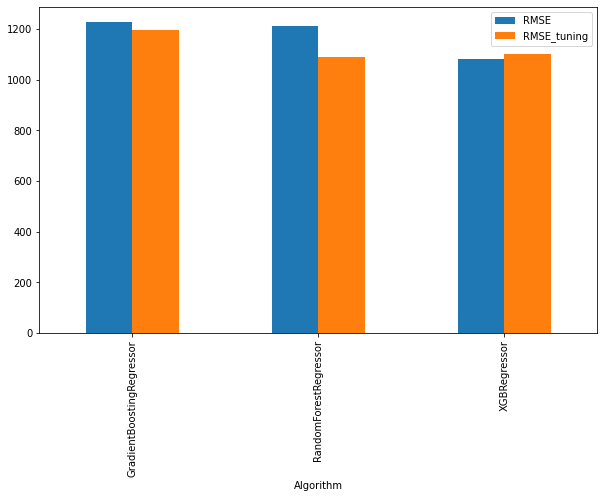

In [16]:
X_train_pre=tfm.fit_transform(X_train)
tuning_model={'GradientBoostingRegressor':GradientBoostingRegressor(),'RandomForestRegressor':RandomForestRegressor(),'XGBRegressor':XGBRegressor(objective='reg:squarederror')}
for i in tuning_model:
  model=tuning_model.get(i)
  rmse[i]=score_model(i,model,X_train_pre,X_train,y_train)
get_score_model(rmse).plot(x="Algorithm",
                y=["RMSE","RMSE_tuning"],
                kind="bar",
                figsize=(10,6))